In [1]:
import numpy as np
import pandas as pd
import random
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM


true x0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
true f: [0.         0.01123988 0.01207819 0.01155182 0.02688619 0.
 0.01019029 0.         0.         0.        ]
a = 1.8531667261047913, b = 1.5312904682995265


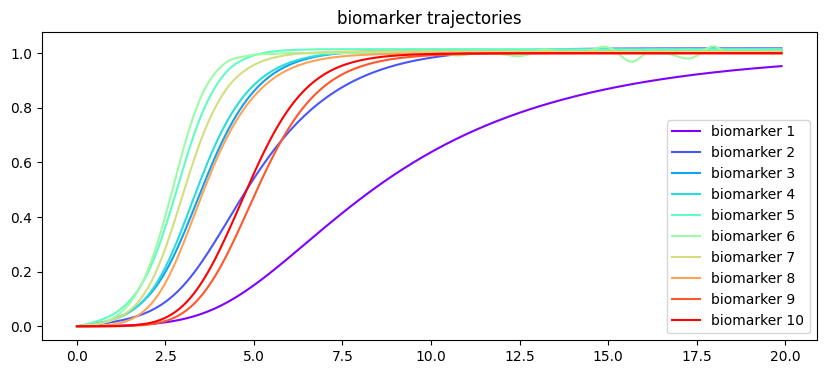

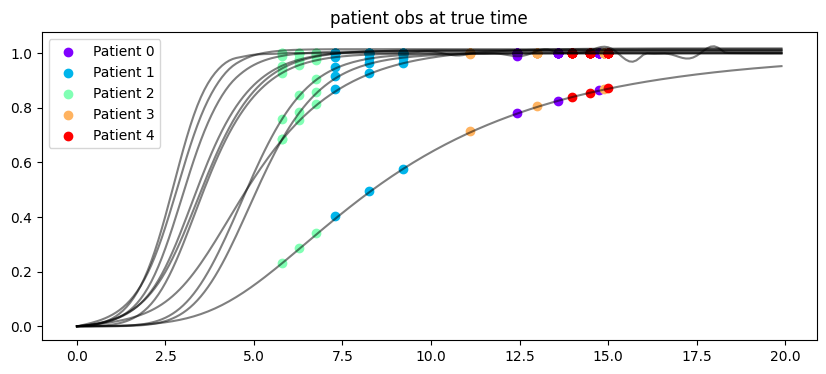

(600, 10) (600,) (600,) (600,) (600,)


In [2]:
# params
n_biomarkers = 10
t_max = 20
t_span = np.linspace(0, t_max, 8000)
noise_level = 0.0
n_patients = 200
n_patient_obs = 3

# fit and transform
t, x_true, K, x0, f, scalar_K  = generate_logistic_model(n_biomarkers=n_biomarkers, t_max=t_max)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

df, cog_a, cog_b = generate_synthetic_data(
    n_biomarkers = n_biomarkers,
    t_max = t_max, 
    noise_level = noise_level,
    n_patients = n_patients,
    n_patient_obs = n_patient_obs,
    x_true=x_true, 
    t=t,
)
plot_biomarker_trajectories(t, x_true, n_biomarkers=n_biomarkers)
plot_true_observations(df, t, x_true)

biomarker_cols = [col for col in df.columns if col.startswith("biomarker_")]

X = df[biomarker_cols].values       # (n_obs, n_biomarkers)
dt = df["dt"].values                # (n_obs,)
ids = df["patient_id"].values       # (n_obs,)
cog = df["cognitive_score"].values  # (n_obs,)
beta_true = df["beta_true"].values 

print(X.shape, dt.shape, ids.shape, cog.shape, beta_true.shape)

In [3]:
import matplotlib.pyplot as plt

def plot_theta_error_history(theta_history: np.ndarray, n_biomarkers: int,
                             f_true: np.ndarray, s_true: np.ndarray, scalar_K_true: float) -> None:
    """
    Plots normalized error of each parameter group over EM iterations.
    """
    num_iterations = theta_history.shape[1]
    f_error_history = []
    s_error_history = []
    scalar_K_error_history = []

    for iteration in range(num_iterations):
        theta = theta_history[:,iteration]

        f_est = theta[0:n_biomarkers]
        s_est = theta[n_biomarkers:2*n_biomarkers]
        scalar_K_est = theta[-1]

        f_err = np.mean(np.abs(f_true - f_est)) / (np.mean(np.abs(f_true)) + 1e-8)
        s_err = np.mean(np.abs(s_true - s_est)) / (np.mean(np.abs(s_true)) + 1e-8)
        k_err = np.abs(scalar_K_true - scalar_K_est) / (np.abs(scalar_K_true) + 1e-8)

        f_error_history.append(f_err)
        s_error_history.append(s_err)
        scalar_K_error_history.append(k_err)
        
    plt.figure(figsize=(10, 4))
    plt.plot(f_error_history, label="f error")
    plt.plot(s_error_history, label="s error")
    plt.plot(scalar_K_error_history, label="scalar error")
    plt.xticks(range(0,num_iterations))
    plt.title("theta error")
    plt.xlabel("iteration")
    plt.ylabel("theta error")
    plt.legend()
    plt.show()

In [4]:
def plot_beta_error_history(beta_history: np.ndarray, beta_true: np.ndarray) -> None:
    """
    Plots mean beta estimation error over EM iterations.
    """
    num_iterations = beta_history.shape[1]
    beta_error_mean_history = np.zeros(num_iterations)
    beta_error_std_history = np.zeros(num_iterations)
    for iteration in range(num_iterations):
        beta_estimated = beta_history[:, iteration]    
        beta_error = np.abs(beta_estimated - beta_true)
        beta_error_mean_history[iteration] = np.mean(beta_error)
        beta_error_std_history[iteration] = np.std(beta_error)

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(beta_error_mean_history)), beta_error_mean_history)
    plt.fill_between(range(len(beta_error_mean_history)),
                     beta_error_mean_history - beta_error_std_history,
                     beta_error_mean_history + beta_error_std_history,
                     alpha = 0.2)
    plt.ylim([0, max(beta_error_mean_history)])
    plt.xticks(range(0,num_iterations))
    plt.xlabel("iteration")
    plt.ylabel("mean beta error")
    plt.title("beta error")
    plt.show()

In [5]:
cog_true = np.array([cog_a, cog_b])
def plot_cog_regression_history(cog_history: np.ndarray, cog_true: np.ndarray):
    n_params, num_iterations = cog_history.shape
    
    # cog_error = np.zeros_like(cog_history)
    # for i in range(num_iterations):
    #     cog_error[:,i] = cog_error[:,i] - cog_true
    
    plt.figure(figsize=(10, 5))
    for i in range(n_params):
        label = f"a_{i}" if i < n_params - 1 else "b"
        plt.plot(range(num_iterations), cog_history[i,:], label=label)
    plt.legend()
    plt.xlabel("iteration")
    plt.ylabel("estimated coefficient value")
    plt.title("cog_parameters")
    plt.grid(True)
    plt.show()

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.5136350483846033
initial beta: (200,)
prepend complete


  7%|▋         | 2/30 [00:03<00:58,  2.08s/it]

100%|██████████| 30/30 [04:35<00:00,  9.18s/it]


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.00018213 0.01451006 0.01846029 0.01790114 0.04245028 0.00744559
 0.01691024 0.00112982 0.         0.        ]
THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0.    0.015 0.018 0.018 0.042 0.007 0.017 0.001 0.    0.   ]
s:  [0.991 1.007 1.002 1.002 1.001 0.998 1.001 1.    0.999 0.999]
s_k:  1.022232590530968

BETA SUMMARY:
beta true:  [12.442  7.301  5.794 11.114 13.978  6.017  0.608  5.207  5.763  6.512]
beta final:  [12.206  6.984  5.411 10.896 13.789  5.679  0.397  4.871  5.4    6.202]


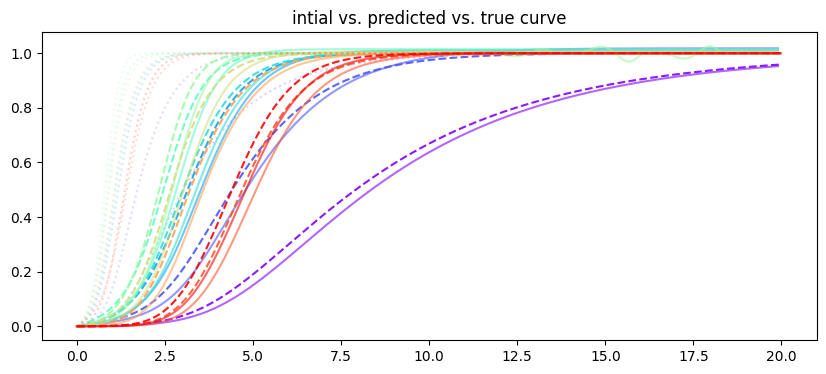

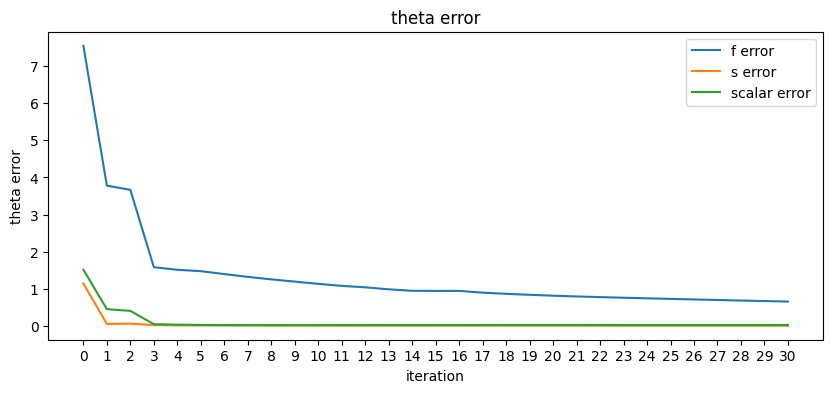

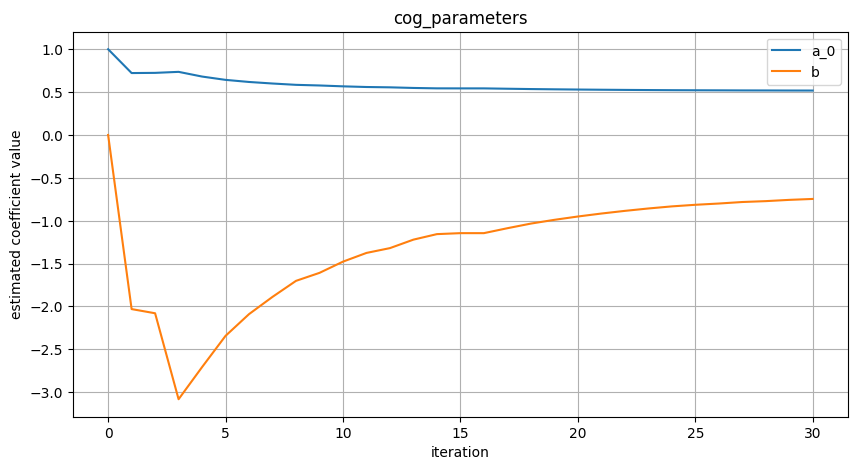

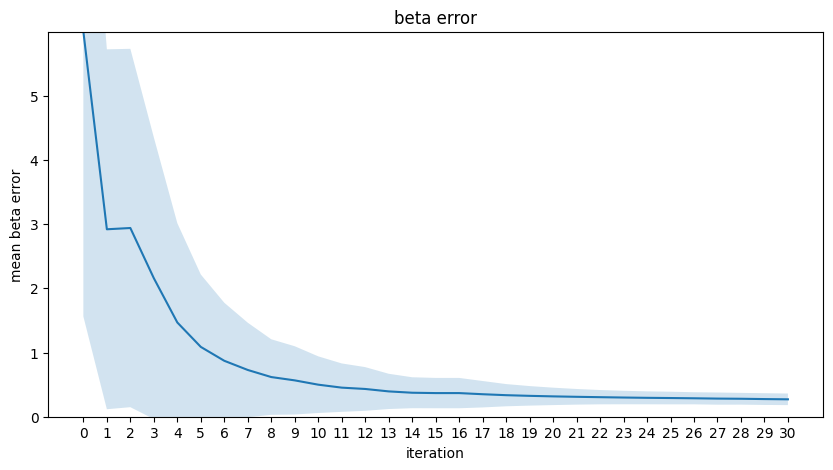

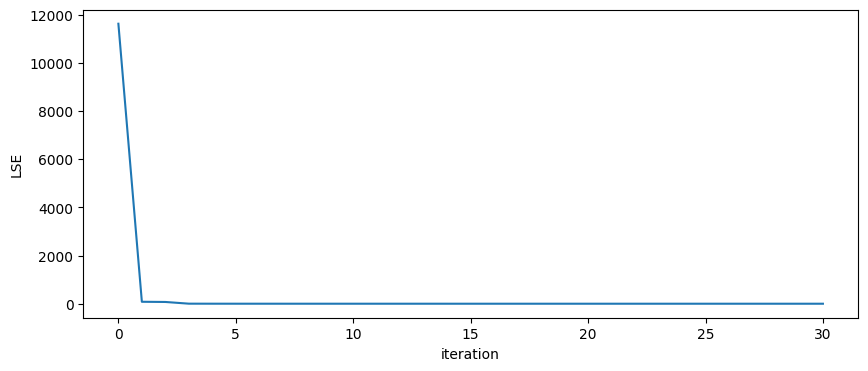

In [6]:
em_model_0 = EM(num_iterations=30, t_max=t_max, step=0.01,
                use_jacobian=True, lambda_cog=0.0)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
beta_true = beta_true[::3]
print("beta true: ",np.round(beta_true[0:10], 3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
plot_theta_error_history(theta_history, n_biomarkers, f_true, s_true, scalar_K_true)
plot_cog_regression_history(em_model_0.cog_regression_history, cog_true)
beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)
plot_lse(lse_history)

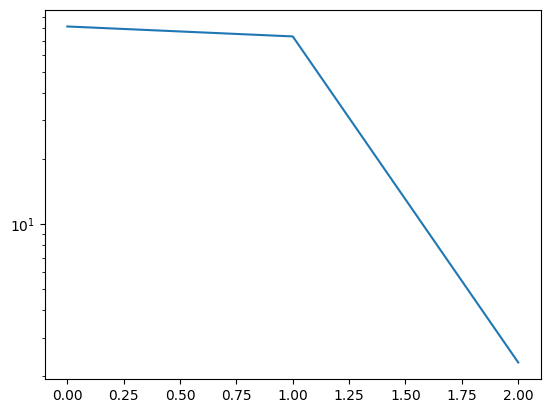

In [7]:
plt.figure()
plt.plot(lse_history[1:4])
#plt.xscale('log')
plt.yscale('log')
plt.show()

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.5136350483846033
initial beta: (200,)
prepend complete


100%|██████████| 30/30 [00:33<00:00,  1.11s/it]



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.         0.         0.00076285 0.00117695 0.         0.00358763
 0.         0.01551705 0.1793988  0.02303428]
THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0.    0.    0.001 0.001 0.    0.004 0.    0.016 0.179 0.023]
s:  [0.775 1.001 1.021 1.014 1.022 1.009 1.008 0.964 0.859 0.884]
s_k:  1.381839971254898

BETA SUMMARY:
beta true:  [12.442 11.114  0.608  6.512  2.145 17.218 11.055  3.383  9.419  5.143]
beta final:  [20.     7.796  5.174 20.    20.     5.69   0.     4.445  5.87  11.556]


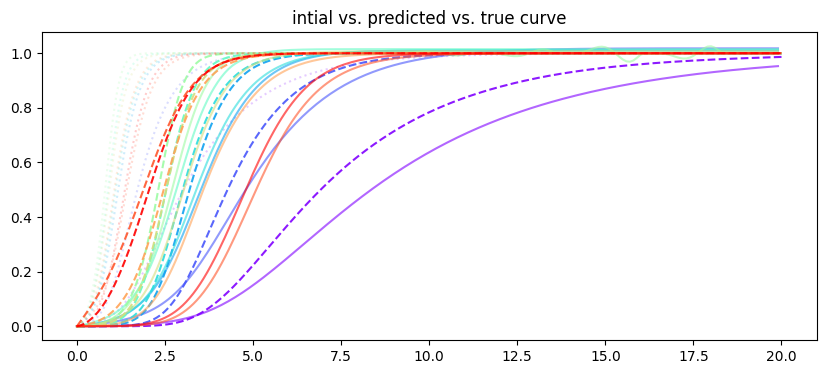

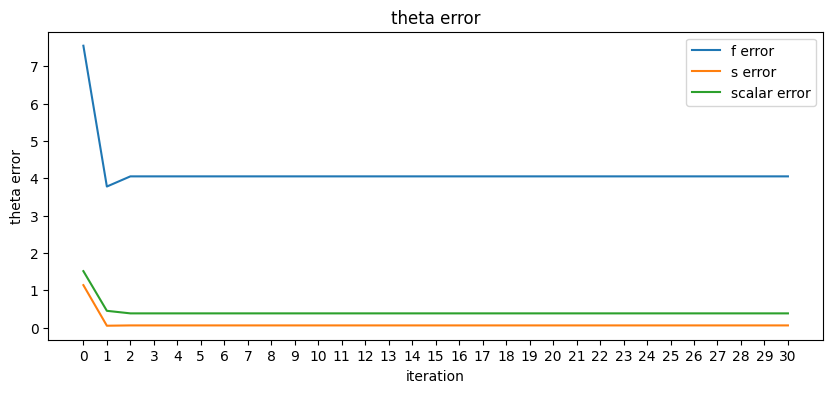

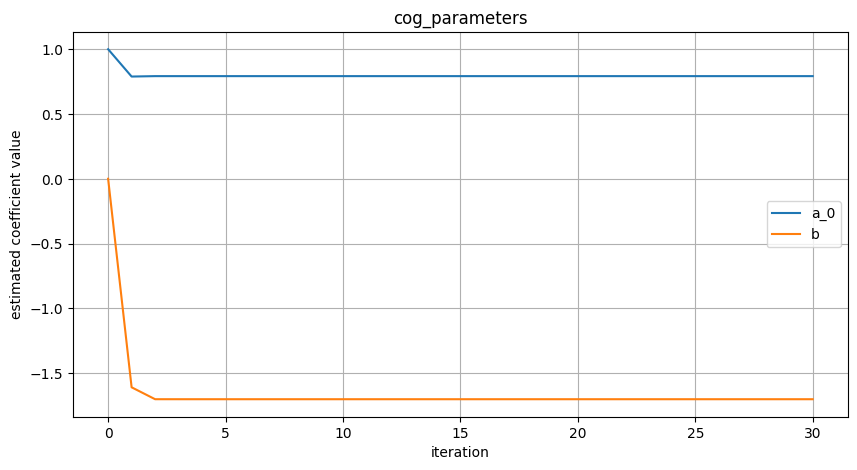

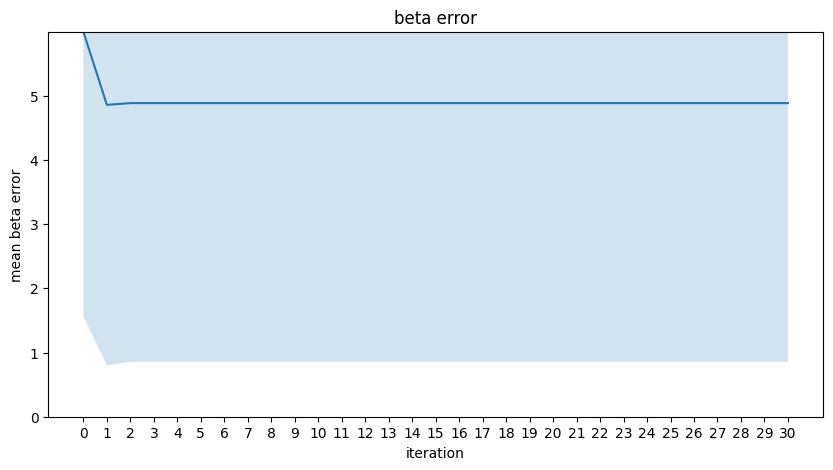

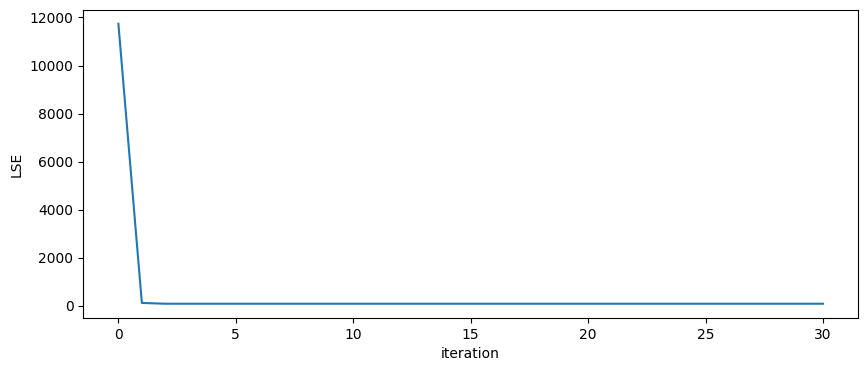

In [7]:
em_model_0 = EM(num_iterations=30, t_max=t_max, step=0.01,
                use_jacobian = True, lambda_cog=0.001)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
beta_true = beta_true[::3]
print("beta true: ",np.round(beta_true[0:10], 3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
plot_theta_error_history(theta_history, n_biomarkers, f_true, s_true, scalar_K_true)
plot_cog_regression_history(em_model_0.cog_regression_history, cog_true)
beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)
plot_lse(lse_history)

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.5136350483846033
initial beta: (200,)
prepend complete


100%|██████████| 30/30 [00:33<00:00,  1.13s/it]



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.00232025 0.0195678  0.00083496 0.00132113 0.00154128 0.00228739
 0.00245475 0.03451039 0.15825397 0.03015777]
THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0.002 0.02  0.001 0.001 0.002 0.002 0.002 0.035 0.158 0.03 ]
s:  [0.75  0.971 1.02  1.025 1.027 1.011 1.009 0.969 0.862 0.888]
s_k:  1.2433561400495285

BETA SUMMARY:
beta true:  [12.442 11.114  0.608  6.512  2.145 17.218 11.055  3.383  9.419  5.143]
beta final:  [20.    12.015  6.602 19.794 20.     8.085  0.193  5.725 10.615 10.362]


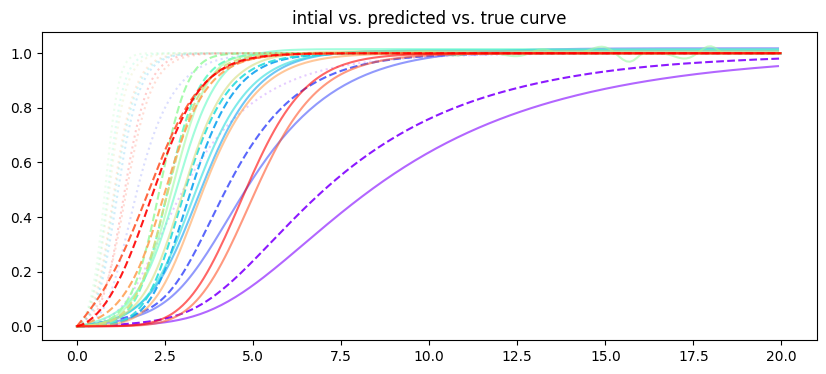

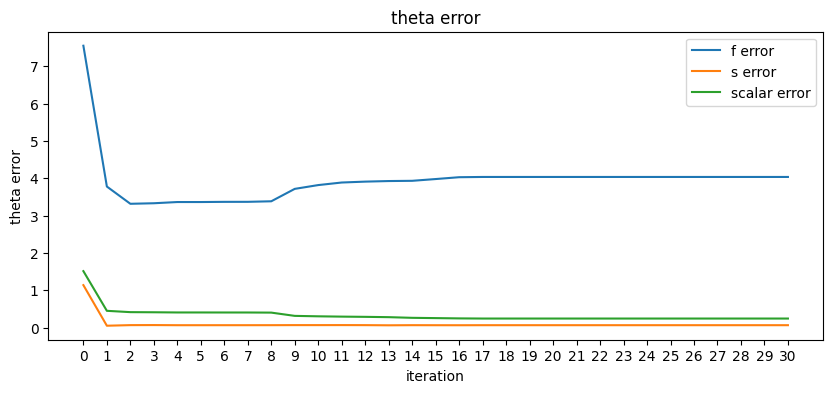

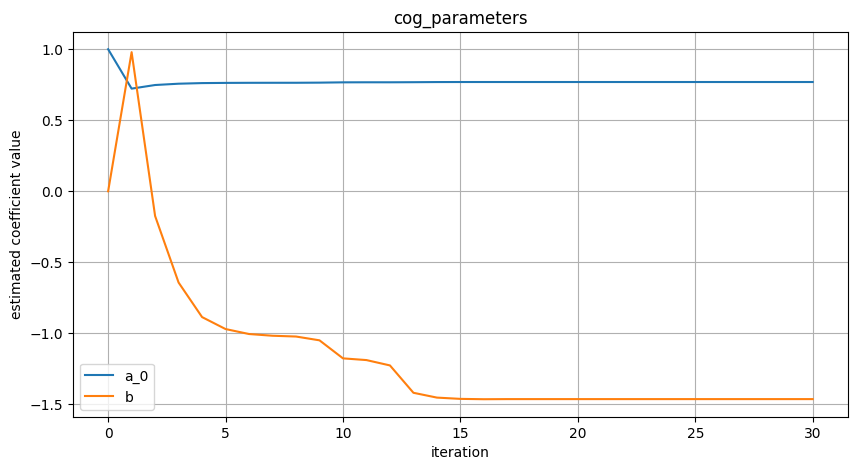

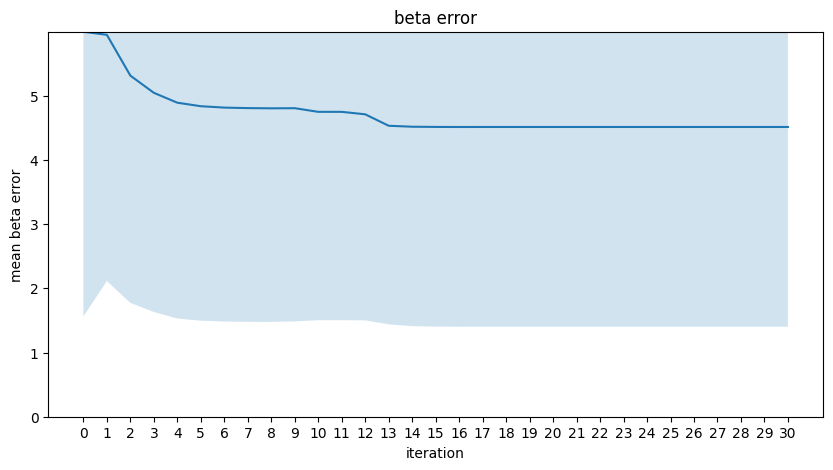

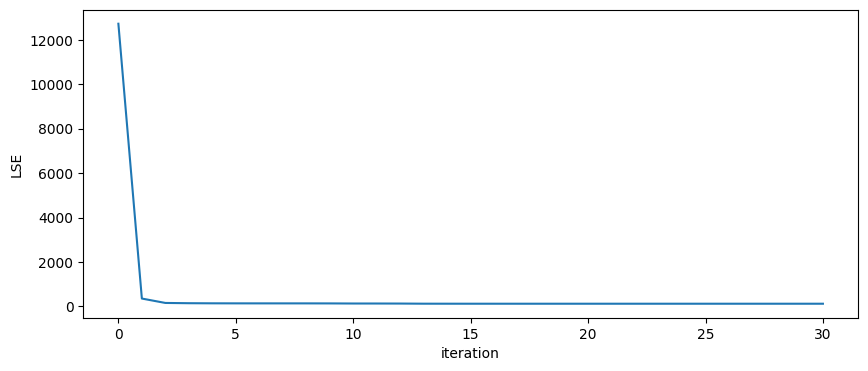

In [8]:
em_model_0 = EM(num_iterations=30, t_max=t_max, step=0.01,
                use_jacobian = True, lambda_cog=0.01)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
beta_true = beta_true[::3]
print("beta true: ",np.round(beta_true[0:10], 3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
plot_theta_error_history(theta_history, n_biomarkers, f_true, s_true, scalar_K_true)
plot_cog_regression_history(em_model_0.cog_regression_history, cog_true)
beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)
plot_lse(lse_history)

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.5136350483846033
initial beta: (200,)
prepend complete


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:43<00:00,  1.45s/it]



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.04263786 0.00299547 0.00086806 0.00379491 0.00156809 0.00398186
 0.00608724 0.01664778 0.18412086 0.0427945 ]
THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0.043 0.003 0.001 0.004 0.002 0.004 0.006 0.017 0.184 0.043]
s:  [0.755 0.983 1.017 1.013 1.017 1.005 1.002 0.962 0.848 0.874]
s_k:  1.0709096329676275

BETA SUMMARY:
beta true:  [12.442 11.114  0.608  6.512  2.145 17.218 11.055  3.383  9.419  5.143]
beta final:  [14.507  8.742  6.7   13.191 17.82   7.437  0.652  6.412  8.383  8.389]


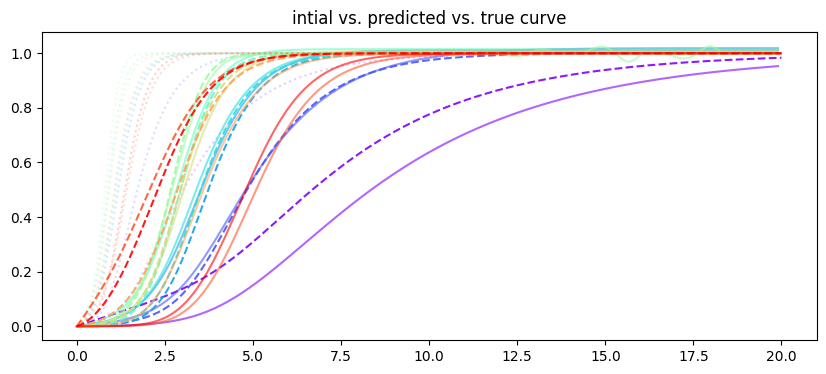

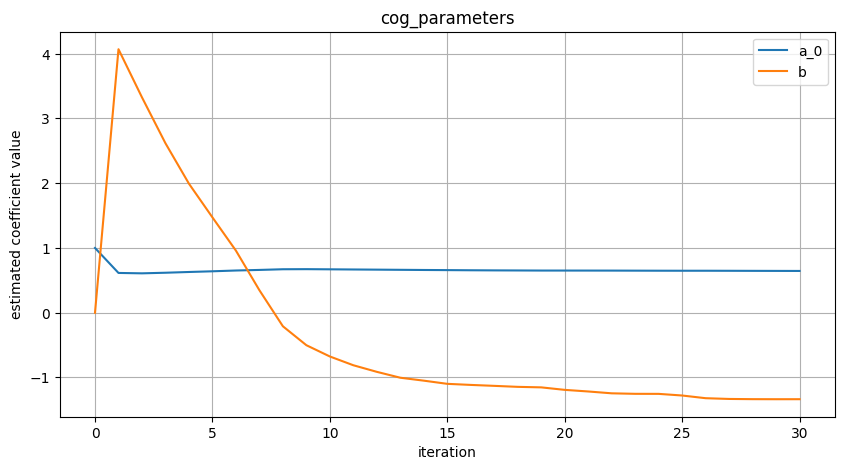

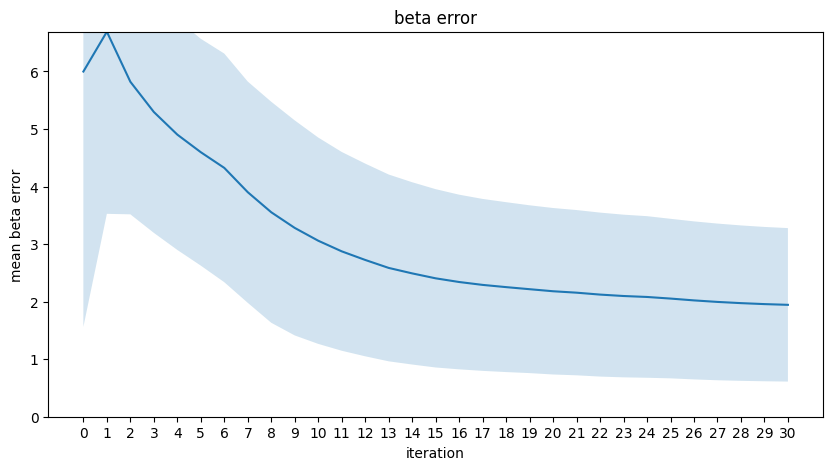

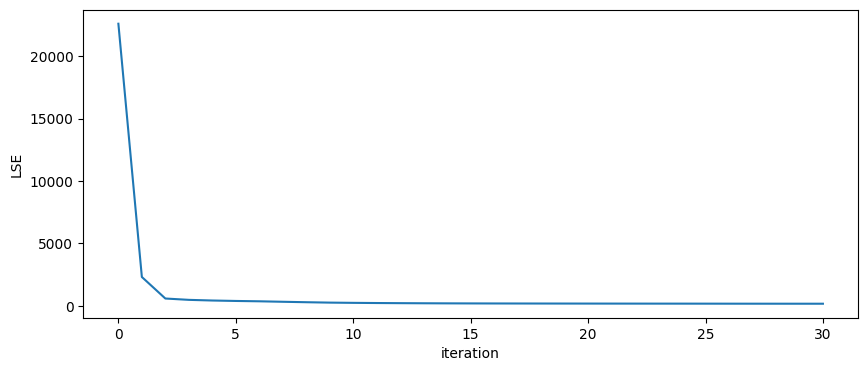

In [ ]:
em_model_0 = EM(num_iterations=30, t_max=t_max, step=0.01,
                use_jacobian = True, lambda_cog=0.1)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
beta_true = beta_true[::3]
print("beta true: ",np.round(beta_true[0:10], 3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
plot_theta_error_history(theta_history, n_biomarkers, f_true, s_true, scalar_K_true)
plot_cog_regression_history(em_model_0.cog_regression_history, cog_true)
beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)
plot_lse(lse_history)

initial conditions:
n_patients: 200, n_obs: 600
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.5136350483846033
initial beta: (200,)
prepend complete


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:31<00:00,  1.05s/it]



SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.0031629  0.00082936 0.         0.01307491 0.00296746 0.00075393
 0.0082571  0.01988102 0.15832622 0.00078198]
THETA SUMMARY:
true theta:
f:  [0.    0.011 0.012 0.012 0.027 0.    0.01  0.    0.    0.   ]
s:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
s_k:  1.0
final theta:
f:  [0.003 0.001 0.    0.013 0.003 0.001 0.008 0.02  0.158 0.001]
s:  [0.598 0.803 0.884 0.889 0.924 0.928 0.91  0.875 0.794 0.817]
s_k:  1.23517818519267

BETA SUMMARY:
beta true:  [12.442 11.114  0.608  6.512  2.145 17.218 11.055  3.383  9.419  5.143]
beta final:  [16.667 13.349 12.45  15.581 18.93  12.695  8.06  12.172 12.333 13.192]


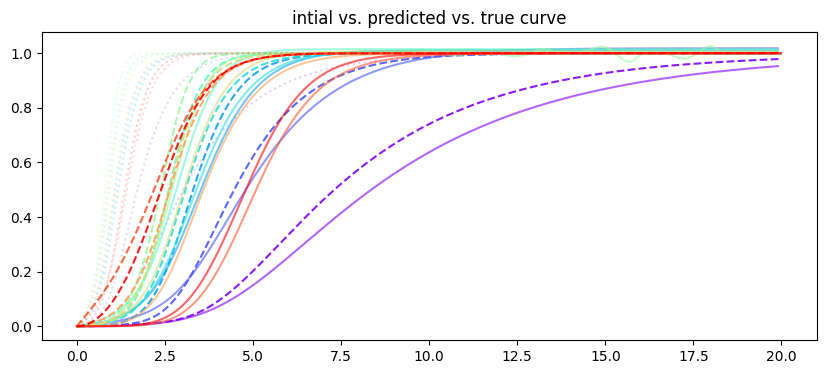

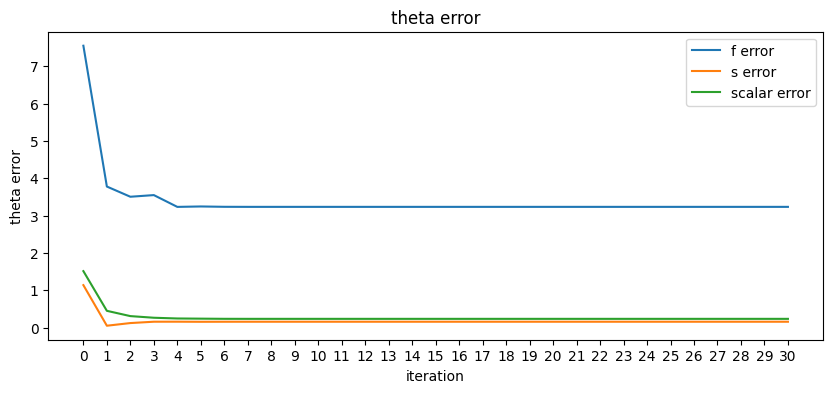

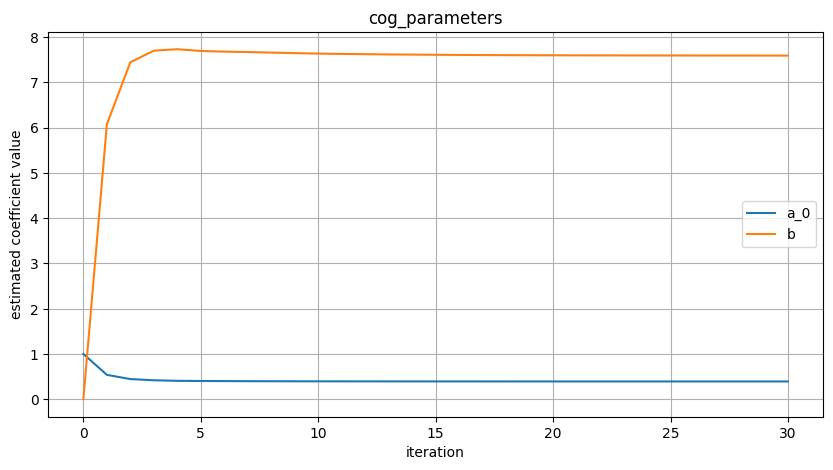

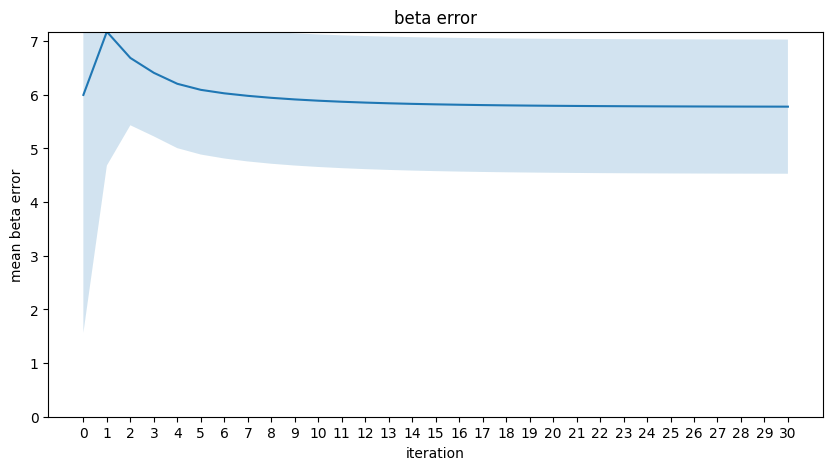

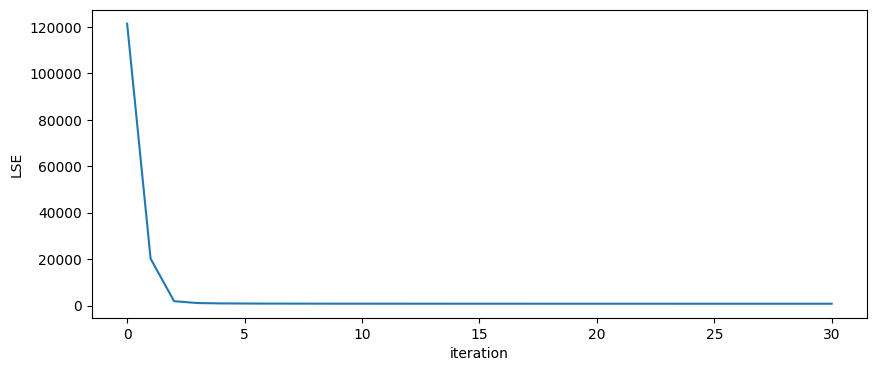

In [10]:
em_model_0 = EM(num_iterations=30, t_max=t_max, step=0.01,
                use_jacobian=True, lambda_cog=1.0)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K)

f_true = f 
s_true = np.ones(n_biomarkers)
scalar_K_true = 1.0 

#plot_initial_beta_guess(df, em_model_0.beta_iter_, t, x_true)
# histories
theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

# initial parameters
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]

print("THETA SUMMARY:")
print("true theta:")
print("f: ", np.round(f_true, 3))
print("s: ", np.round(s_true, 3))
print("s_k: ", scalar_K_true)

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s_k: ", final_theta[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
beta_true = beta_true[::3]
print("beta true: ",np.round(beta_true[0:10], 3))
print("beta final: ", np.round(beta_history[0:10,-1], 3))

scaled_final_model = np.zeros_like(final_model)
for idx, s in enumerate(final_s):
    scaled_final_model[idx, :] = s * final_model[idx, :]

initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

# plotting
plot_theta_fit_comparison(t, t_span, x_true, initial_model, final_model, n_biomarkers)
plot_theta_error_history(theta_history, n_biomarkers, f_true, s_true, scalar_K_true)
plot_cog_regression_history(em_model_0.cog_regression_history, cog_true)
beta_true = df.groupby("patient_id")["beta_true"].first().values
plot_beta_error_history(beta_history, beta_true)
plot_lse(lse_history)